In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('rymldata01v(1).csv')
data.columns = data.columns.str.lower()
data['sale_date'] = pd.to_datetime(data['sale_date'])
data.shape

(5113, 5)

>> Selecting the skuid : 3589974 for whid :28902

In [3]:
data_3589974 = data.loc[(data['whidx'] == 28902) & (data['skuidx'] == 3589974)]
data_3589974 = data_3589974.sort_values('sale_date',ascending = False)
data_3589974.shape

(260, 5)

In [4]:
data_3589974.columns

Index(['unnamed: 0', 'whidx', 'skuidx', 'sale_date', 'total_qty'], dtype='object')

<AxesSubplot:xlabel='sale_date', ylabel='total_qty'>

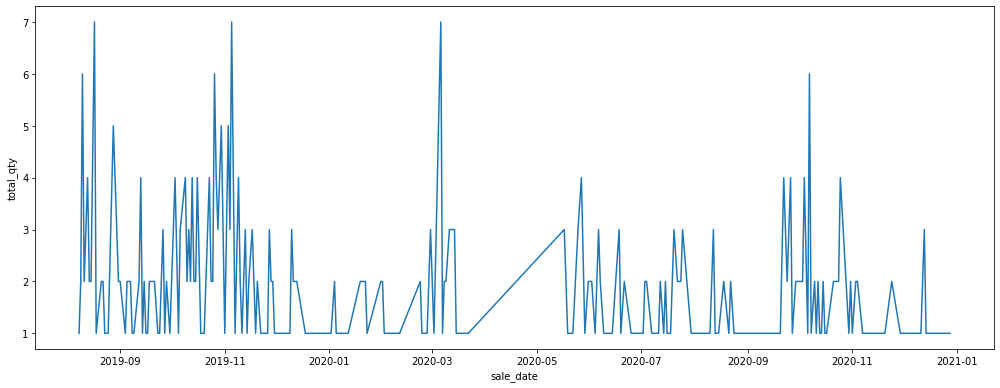

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = [14.00, 5.50]
plt.rcParams["figure.autolayout"] = True

sns.lineplot(x = 'sale_date',y = 'total_qty',data = data_3589974)

From the above lineplot of the time series we can infer that there are massive jumps in the demand indicating possible changepoints.
Hence we must investigate our possible change points by considering a visual threshold.

<AxesSubplot:xlabel='sale_date', ylabel='total_qty'>

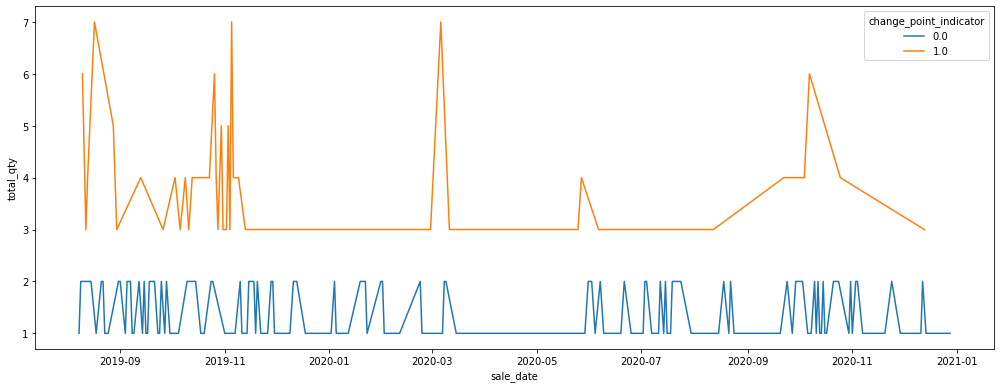

In [6]:
change_point_dates = list(data_3589974.loc[(data_3589974['total_qty'] > 2)].sale_date.unique())
data_3589974.loc[(data_3589974['sale_date'].isin(change_point_dates)),'change_point_indicator'] = 1
data_3589974.loc[~(data_3589974['sale_date'].isin(change_point_dates)),'change_point_indicator'] = 0
sns.lineplot(x = 'sale_date',y = 'total_qty',hue = data_3589974.change_point_indicator ,data = data_3589974)

<AxesSubplot:xlabel='sale_date', ylabel='total_qty'>

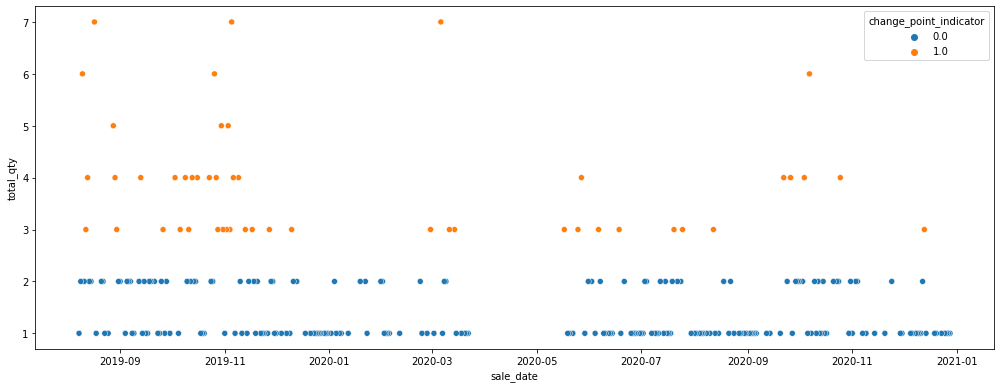

In [7]:
sns.scatterplot(x = 'sale_date',y = 'total_qty',hue = data_3589974.change_point_indicator ,data = data_3589974)

In the above lineplot & scatterplot, we have considered total_qty > 2 as the change points in demand 
and hence they are colour coded as yellow 
> Now we shall investigate a data driven approach to detect the change points 
> We shall check if the daily demand exceeds the median on a monthly level.

In [8]:
data_3589974['MOS'] = data_3589974.sale_date.dt.to_period('M')
mos_median_data = data_3589974.groupby('MOS').agg(median_demand = pd.NamedAgg('total_qty','median')).reset_index()
data_3589974 = pd.merge(data_3589974,mos_median_data,how = 'left',on = 'MOS')
data_3589974

,unnamed: 0,whidx,skuidx,sale_date,total_qty,change_point_indicator,MOS,median_demand
0,3037,28902,3589974,2020-12-28,1,0.0,2020-12,1.0
1,3036,28902,3589974,2020-12-27,1,0.0,2020-12,1.0
2,3035,28902,3589974,2020-12-26,1,0.0,2020-12,1.0
3,3034,28902,3589974,2020-12-25,1,0.0,2020-12,1.0
4,3033,28902,3589974,2020-12-23,1,0.0,2020-12,1.0
...,...,...,...,...,...,...,...,...
255,4840,28902,3589974,2019-08-12,3,1.0,2019-08,2.0
256,4332,28902,3589974,2019-08-11,2,0.0,2019-08,2.0
257,5097,28902,3589974,2019-08-10,6,1.0,2019-08,2.0
258,4331,28902,3589974,2019-08-09,2,0.0,2019-08,2.0


In [9]:
data_3589974.loc[(data_3589974['total_qty'] > data_3589974['median_demand']),'change_point_indicator2'] = 1
data_3589974.loc[(data_3589974['total_qty'] <= data_3589974['median_demand']),'change_point_indicator2'] = 0

Number of change points

In [10]:
data_3589974['change_point_indicator2'].sum()

75.0

<AxesSubplot:xlabel='sale_date', ylabel='total_qty'>

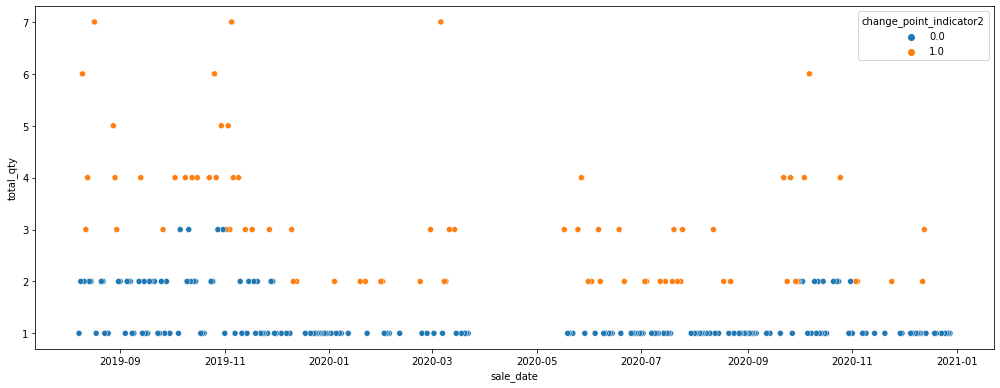

In [11]:
sns.scatterplot(x = 'sale_date',y = 'total_qty',hue = data_3589974.change_point_indicator2 ,data = data_3589974)

Post detecting the change points based on the higher shift of demand from their median on a monthly level, 
we will separately look at the two situations   

<AxesSubplot:xlabel='sale_date', ylabel='total_qty'>

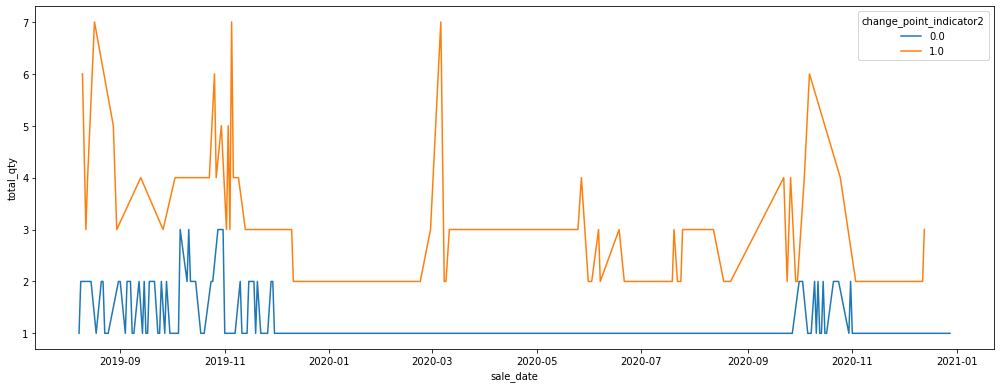

In [41]:
sns.lineplot(x = 'sale_date',y = 'total_qty',hue = data_3589974.change_point_indicator2 ,data = data_3589974)

In [51]:
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
data_3589974.set_index(data_3589974.sale_date,inplace=True)

<AxesSubplot:xlabel='sale_date'>

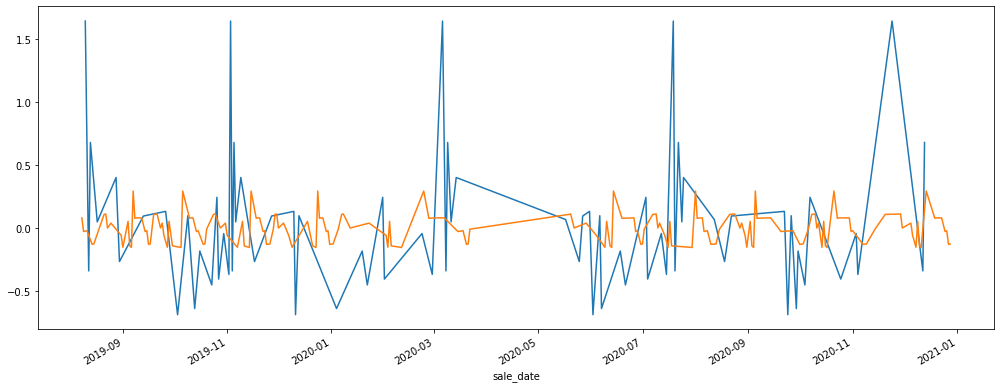

In [57]:
result1 = seasonal_decompose(x = data_3589974.loc[(data_3589974['change_point_indicator2'] == 1)].total_qty,
                            model='additive',period=18)
result2 = seasonal_decompose(x = data_3589974.loc[(data_3589974['change_point_indicator2'] == 0)].total_qty,
                            model='additive',period=18)
result1.seasonal.plot()
result2.seasonal.plot()

<AxesSubplot:xlabel='sale_date'>

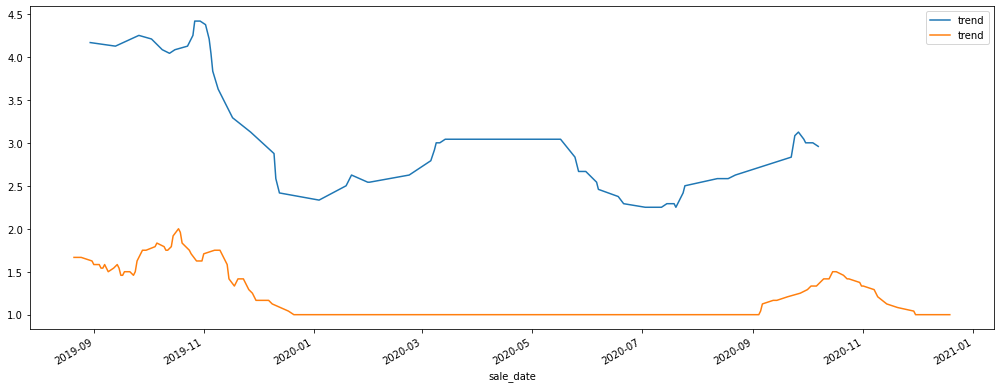

In [48]:
result1.trend.plot(legend = True)
result2.trend.plot(legend = True)

# Spliting the data into train & test based on the sale_date 

In [53]:
f"sale_date start :{data_3589974['sale_date'].min()} & sale_date end :{data_3589974['sale_date'].max()}"

'sale_date start :2019-08-08 00:00:00 & sale_date end :2020-12-28 00:00:00'

Tagging year-quarter tag

In [20]:
data_3589974['quarter'] = data_3589974['sale_date'].dt.quarter
data_3589974['Year'] = data_3589974['sale_date'].dt.to_period('Y')
data_3589974['quarter_year'] = data_3589974['Year'].astype(str) + '_' + data_3589974['quarter'].astype(str)
data_3589974['quarter_year']

0      2020_4
1      2020_4
2      2020_4
3      2020_4
4      2020_4
        ...  
255    2019_3
256    2019_3
257    2019_3
258    2019_3
259    2019_3
Name: quarter_year, Length: 260, dtype: object

In [21]:
train = data_3589974.loc[data_3589974['sale_date'] <= '2020-09-30 00:00:00']
test = data_3589974.loc[data_3589974['sale_date'] > '2020-09-30 00:00:00']
test.shape[0]

46

[Changepoints First Choice ]From each quarter of the year we are picking up 1 change point in the ascending order of time

In [48]:
quarters = list(train['quarter_year'].unique())
cp = []
for qy in quarters:
    cp_ = train.loc[(train['quarter_year'] == qy) & (train['change_point_indicator2'] == 1)].sale_date.max()
    cp += [cp_]

In [49]:
cp

[Timestamp('2020-09-30 00:00:00'),
 Timestamp('2020-06-21 00:00:00'),
 Timestamp('2020-03-14 00:00:00'),
 Timestamp('2019-12-13 00:00:00'),
 Timestamp('2019-09-26 00:00:00')]

[Changepoints Second Choice] Breaking the list of changepoints into a sections of change points

In [39]:
cp = list(train.loc[train['change_point_indicator2'] == 1].sale_date.unique())

In [80]:
p_feed = train[['sale_date','total_qty']]
p_feed = p_feed.rename(columns = {'sale_date':'ds','total_qty':'y'})
p_feed['sale_date'] = pd.to_datetime(p_feed['ds']) 
p_feed['cap'] = p_feed['y'].max()

In [77]:
import prophet
from prophet import Prophet
Prophet()

In [81]:
import prophet
from prophet import Prophet
Model = Prophet(growth = 'logistic',
                changepoints = cp,
                changepoint_prior_scale=0.1,
                holidays_prior_scale=8,
                n_changepoints=25,
                changepoint_range=0.9,
                yearly_seasonality='auto',
                weekly_seasonality='auto',
                daily_seasonality='auto',
                holidays = None,
                seasonality_mode='additive')
Model.add_country_holidays(country_name='TH')
Model.add_seasonality(name = 'bimonthly',period = 18,mode = 'additive',fourier_order = 10)
Model.fit(p_feed)

C:\Users\Indranil\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\hdays.py:485: Warning: We only support Asalha Puja holiday from 2006 to 2025
  warnings.warn(warning_msg, Warning)
C:\Users\Indranil\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\hdays.py:532: Warning: We only support Vassa holiday from 2006 to 2020
  warnings.warn(warning_msg, Warning)
21:16:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\Indranil\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\hdays.py:485: Warning: We only support Asalha Puja holiday from 2006 to 2025
  warnings.warn(warning_msg, Warning)
C:\Users\Indranil\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\hdays.py:532: Warning: We only support Vassa holiday from 2006 to 2020
  warnings.warn(warning_msg, Warning)
C:\Users\Indranil\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\hdays.py:485: Warning: We only support Asalha Puja holiday from 2006 to 2025
  warnings.warn(warning_msg, Warning)
C:\Users\Indranil\AppData\Local\Programs\Python\Python39\lib\site-packages\prophet\hdays.py:532: Warning: We only support Vassa holiday from 2006 to 2020
  warnings.warn(warning_msg, Warning)


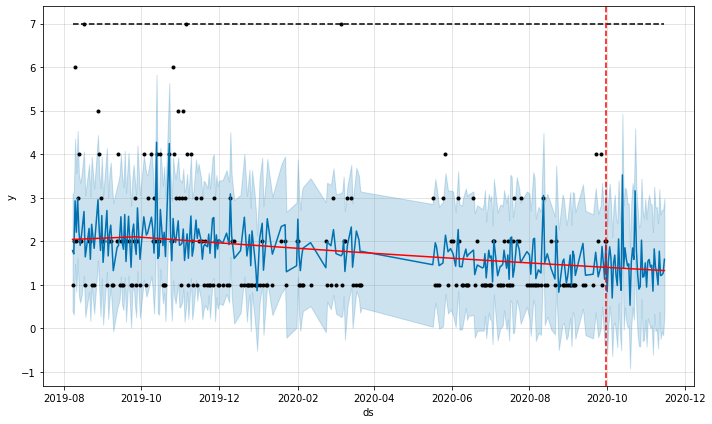

In [82]:
from prophet.plot import add_changepoints_to_plot
future = Model.make_future_dataframe(periods = test.shape[0],freq = 'D')
future['cap'] = p_feed['y'].max()
fcst = Model.predict(future)
fig = Model.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), Model, fcst)

In [83]:
results = pd.concat([test,fcst['yhat']],axis = 1)
results = results[['sale_date','total_qty','yhat']].dropna()

<AxesSubplot:>

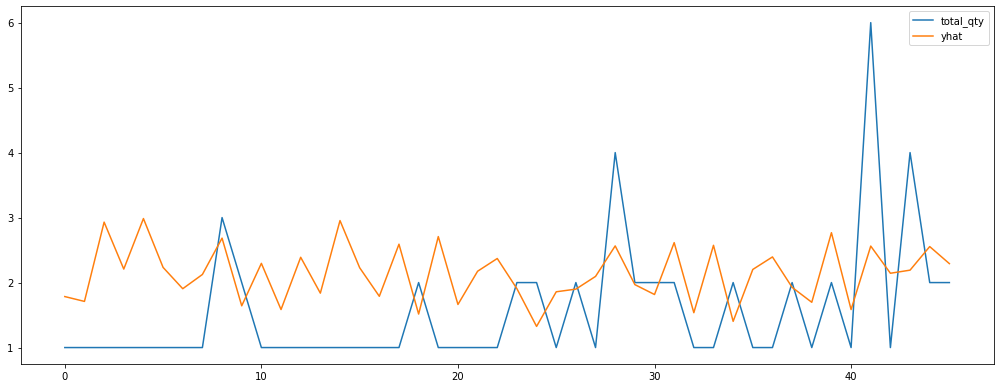

In [84]:
results[['total_qty','yhat']].plot()

In [75]:
def MAPE(data,col1,col2):
    abdiff = (np.abs((data[col1] - data[col2])/data[col1]).mean())*100
    return abdiff
    

In [77]:
def mape(y_true,y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    abs1 = np.abs((y_true - y_pred)/y_true)
    
    return 100*np.mean(abs1)

In [85]:
mape(results.total_qty,results.yhat)

81.41950551155863

In [76]:
MAPE(results,'total_qty','yhat')

80.45296845297176